In [3]:
import pandas as pd

In [ ]:
# 0. Import all libraries
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [21]:
# 1. Import data
file_path = './data/SMCI.csv'
data = pd.read_csv(file_path)

In [7]:
# Delete "$"s and convert data into float numbers
data['Close'] = data['Close/Last'].str.replace('$', '').astype(float)

In [9]:
# 2. Setup Variables
# 2.1 Time horizon set to be 9 years for training, 1 year for validation
# 2.2 time steps for LSTM
time_steps = 90     # tested [30, 60, 90, 120], 90 is the most efficient one

In [10]:
# 3. Data pre-processing
def preprocess_data(train_set, valid_set):
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Normalization
    train_data = scaler.fit_transform(train_set['Close'].values.reshape(-1, 1))
    valid_data = scaler.transform(valid_set['Close'].values.reshape(-1, 1))
    
    x_train, y_train = [], []
    for i in range(time_steps, len(train_data)):
        x_train.append(train_data[i-time_steps:i, 0])
        y_train.append(train_data[i, 0])
    
    x_valid, y_valid = [], []
    for i in range(time_steps, len(valid_data)):
        x_valid.append(valid_data[i-time_steps:i, 0])
        y_valid.append(valid_data[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    x_valid, y_valid = np.array(x_valid), np.array(y_valid)
    x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
    
    return x_train, y_train, x_valid, y_valid, scaler

In [11]:
# 调参：LSTM模型
def build_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [12]:
# 调参：训练模型
def train_model(model, x_train, y_train):
    model.fit(x_train, y_train, epochs=25, batch_size=32)

In [13]:
# 预测函数
def make_prediction(model, x_valid, scaler):
    predictions = model.predict(x_valid)
    predictions = scaler.inverse_transform(predictions)
    return predictions

In [14]:
data['Date'] = pd.to_datetime(data['Date'])
train_set = data[(data['Date'] >= '2014-06-24') & (data['Date'] < '2023-06-24')].copy()
vaild_set = data[(data['Date'] >= '2023-06-25') & (data['Date'] < '2024-06-21')].copy()

In [20]:
print(train_set.shape)
print(vaild_set.shape)

(2266, 7)
(249, 7)


In [16]:
# 调用预处理
x_train, y_train, x_valid, y_valid, scaler = preprocess_data(train_set, vaild_set)
# 训练模型
model = build_model()
train_model(model, x_train, y_train)
#预测
valid_preds = make_prediction(model, x_valid, scaler)

Epoch 1/25


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0023
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.8013e-04
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7612e-04
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6588e-04
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.5435e-04
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.4724e-04
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.1550e-04
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.0362e-04
Epoch 9/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.1512e-04
Epoch 10/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 9.3326e-05
Epoch 11/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.0033e-04
Epoch 12/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 9.4352e-05
Epoch 13/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.0410e-04
Epoch 14/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.7080e-05
Epoch 15/25
68/68 ━━━━━━━━━━━━

In [17]:
print(valid_preds)

[[712.1833 ]
 [691.2621 ]
 [664.746  ]
 [638.9223 ]
 [618.0354 ]
 [599.82935]
 [570.38007]
 [544.4299 ]
 [513.84546]
 [484.95203]
 [459.38248]
 [436.62747]
 [421.00662]
 [411.43674]
 [404.8254 ]
 [397.35608]
 [389.1479 ]
 [359.0659 ]
 [327.75684]
 [303.5835 ]
 [290.89087]
 [287.927  ]
 [291.10083]
 [297.7899 ]
 [300.47437]
 [295.30673]
 [287.03677]
 [277.28326]
 [269.96143]
 [265.23032]
 [264.5233 ]
 [266.9395 ]
 [270.53662]
 [273.23416]
 [278.13715]
 [282.6475 ]
 [289.08542]
 [296.39746]
 [297.8853 ]
 [295.10065]
 [286.14664]
 [274.2813 ]
 [262.5804 ]
 [255.4076 ]
 [248.5277 ]
 [242.88861]
 [241.08365]
 [242.37315]
 [245.83775]
 [250.66374]
 [258.2796 ]
 [265.3444 ]
 [271.7943 ]
 [275.5689 ]
 [277.41428]
 [278.45807]
 [281.87317]
 [282.1873 ]
 [279.95126]
 [277.6552 ]
 [276.9284 ]
 [269.06332]
 [261.63083]
 [255.42953]
 [250.17676]
 [245.34778]
 [241.45311]
 [239.40247]
 [236.92184]
 [236.19823]
 [233.92992]
 [230.92589]
 [229.16872]
 [228.02638]
 [230.497  ]
 [236.10712]
 [240.68295]

LSTM RMSE on validation set: 23.419100125191154


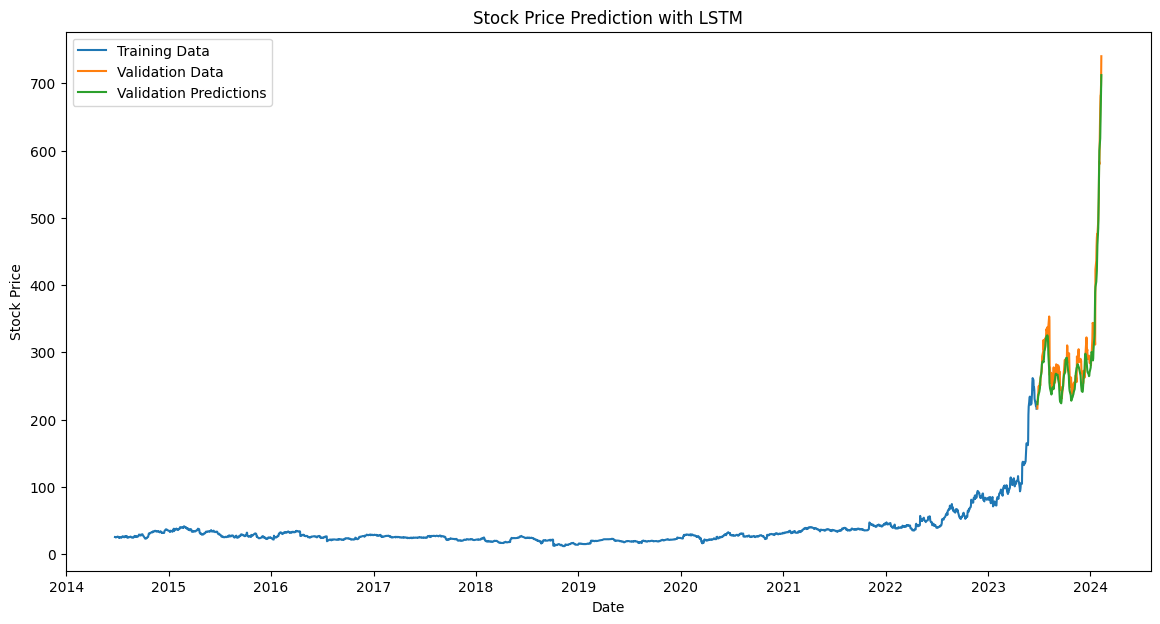

In [18]:
# 计算验证集上的RMSE -- 预测效果非常之差
valid_rmse = np.sqrt(mean_squared_error(vaild_set['Close'].values[time_steps:], valid_preds))
print(f"LSTM RMSE on validation set: {valid_rmse}")

# 可视化LSTM结果
plt.figure(figsize=(14, 7))
plt.plot(train_set['Date'], train_set['Close'], label='Training Data')
plt.plot(vaild_set['Date'][time_steps:], vaild_set['Close'].values[time_steps:], label='Validation Data')
plt.plot(vaild_set['Date'][time_steps:], valid_preds, label='Validation Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()